In [1]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import spacy
from tqdm.auto import tqdm

tqdm.pandas()

E:\Python\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
E:\Python\Anaconda3\lib\site-packages\thinc\neural\train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
E:\Python\Anaconda3\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
E:\Python\Anaconda3\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Seq

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
ALLEN_AI_SUBS_PATH = "../res/allenai/metadata_subset.csv"

In [5]:
df_allen = pd.read_csv(ALLEN_AI_SUBS_PATH)[['source_x', 'title', 'abstract', 'publish_time', 'journal', 'is_pr']]
df_allen = df_allen.fillna('')

print(len(df_allen.index))
df_allen.head(5)

58007


,source_x,title,abstract,publish_time,journal,is_pr
0,PMC,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,The EMBO Journal,True
1,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,The EMBO Journal,True
2,PMC,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,EMBO J,True
3,PMC,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,2002-07-01,The EMBO Journal,True
4,PMC,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,The EMBO Journal,True


In [6]:
raw_txt = df_allen[['title', 'abstract']].agg(' - '.join, axis=1)
raw_txt.values[:2]

array(['Sequence requirements for RNA strand transfer during nidovirus discontinuous subgenomic RNA synthesis - Nidovirus subgenomic mRNAs contain a leader sequence derived from the 5′ end of the genome fused to different sequences (‘bodies’) derived from the 3′ end. Their generation involves a unique mechanism of discontinuous subgenomic RNA synthesis that resembles copy-choice RNA recombination. During this process, the nascent RNA strand is transferred from one site in the template to another, during either plus or minus strand synthesis, to yield subgenomic RNA molecules. Central to this process are transcription-regulating sequences (TRSs), which are present at both template sites and ensure the fidelity of strand transfer. Here we present results of a comprehensive co-variation mutagenesis study of equine arteritis virus TRSs, demonstrating that discontinuous RNA synthesis depends not only on base pairing between sense leader TRS and antisense body TRS, but also on the primary se

In [11]:
def get_adj(txt):
    return ' '.join([str(x.lemma_) for x in nlp(txt) if x.pos_ == 'ADJ'])

raw_adj = raw_txt.progress_apply(get_adj)
raw_adj[:2]

0    nidovirus discontinuous subgenomic subgenomic ...
1    coronavirus murine soluble like cc′ key first ...
dtype: object

In [15]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(raw_adj)
print(dtm_tf.shape)

(58007, 3879)


In [16]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(raw_adj)
print(dtm_tfidf.shape)

(58007, 3879)


In [17]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=25, random_state=4325432)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=25, random_state=4325432)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=25, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=4325432, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [18]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

E:\Python\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.188741  0.061379       1        1  6.477128
19     0.033153 -0.232096       2        1  6.126922
7      0.046699 -0.200505       3        1  6.041321
12     0.121681 -0.215722       4        1  5.352180
15    -0.039650  0.180396       5        1  5.295683
16    -0.072227  0.080767       6        1  5.170487
4     -0.116012 -0.012032       7        1  5.162833
18     0.035579  0.025145       8        1  4.963536
14     0.092094  0.073063       9        1  4.913894
6      0.175808 -0.029177      10        1  4.730641
8      0.011962  0.062873      11        1  4.604408
17     0.190127  0.163765      12        1  4.499462
13    -0.104648 -0.120936      13        1  4.059506
10    -0.222810  0.081175      14        1  4.003569
20    -0.208109  0.077150      15        1  3.761639
5      0.176669  0.138340      16        1  3.623738
3     -0.142870 -0.016886      17        1  2.756515
23    -0.180504  0.020774      18        1  2.724377
11     0.057853 -0.062624      19        1  2.628904
2      0.019505 -0.229957      20        1  2.579594
9      0.029997 -0.156605      21        1  2.534370
21     0.150795  0.084699      22        1  2.457093
0      0.160865  0.128377      23        1  2.080980
24    -0.134164  0.002831      24        1  1.731210
22     0.106945  0.095807      25        1  1.720009, topic_info=     Category          Freq             Term         Total  loglift  logprob
3037  Default  26849.000000      respiratory  26849.000000  30.0000  30.0000
1753  Default  12539.000000       infectious  12539.000000  29.0000  29.0000
3804  Default  30827.000000            viral  30827.000000  28.0000  28.0000
1587  Default  18817.000000            human  18817.000000  27.0000  27.0000
1650  Default   9863.000000           immune   9863.000000  26.0000  26.0000
2760  Default   8865.000000         positive   8865.000000  25.0000  25.0000
131   Default  11204.000000            acute  11204.000000  24.0000  24.0000
3178  Default  10646.000000           severe  10646.000000  23.0000  23.0000
291   Default   6757.000000        antiviral   6757.000000  22.0000  22.0000
647   Default  15043.000000         clinical  15043.000000  21.0000  21.0000
2912  Default   6614.000000           public   6614.000000  20.0000  20.0000
266   Default   5218.000000             anti   5218.000000  19.0000  19.0000
1418  Default   4738.000000           global   4738.000000  18.0000  18.0000
2302  Default   4051.000000         negative   4051.000000  17.0000  17.0000
2576  Default   3551.000000         pandemic   3551.000000  16.0000  16.0000
399   Default   2745.000000            avian   2745.000000  15.0000  15.0000
2975  Default   3740.000000      recombinant   3740.000000  14.0000  14.0000
2346  Default  10579.000000              new  10579.000000  13.0000  13.0000
1760  Default   3683.000000     inflammatory   3683.000000  12.0000  12.0000
3852  Default   2663.000000             wild   2663.000000  11.0000  11.0000
2101  Default   3856.000000          medical   3856.000000  10.0000  10.0000
2914  Default   2372.000000        pulmonary   2372.000000   9.0000   9.0000
1397  Default   4167.000000          genetic   4167.000000   8.0000   8.0000
1290  Default   2237.000000           feline   2237.000000   7.0000   7.0000
578   Default   5198.000000         cellular   5198.000000   6.0000   6.0000
1169  Default   2135.000000       epithelial   2135.000000   5.0000   5.0000
3340  Default   3670.000000       structural   3670.000000   4.0000   4.0000
496   Default   2156.000000           bovine   2156.000000   3.0000   3.0000
2196  Default   6355.000000        molecular   6355.000000   2.0000   2.0000
1783  Default   2716.000000           innate   2716.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
1385  Topic25    134.237688          gastric    170.723695   3

In [19]:
tf_cluster_assignment = lda_tf.transform(dtm_tf).argmax(axis=1)

#### Most common topics

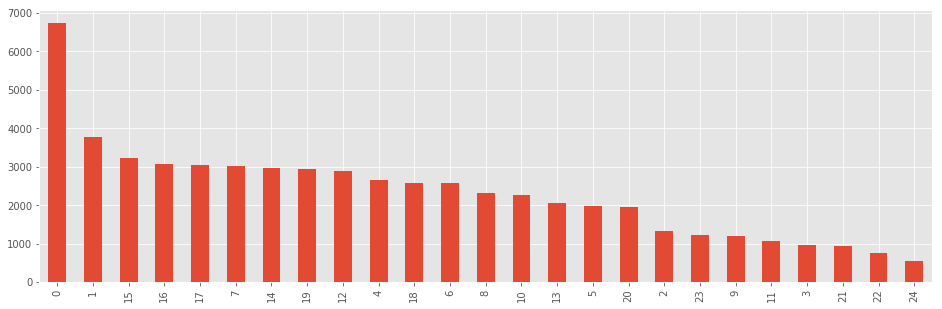

In [20]:
df_allen['tf_cluster'] = tf_cluster_assignment
df_allen.tf_cluster.value_counts().plot(kind='bar', figsize=(16,5))

#### Most common source per topic

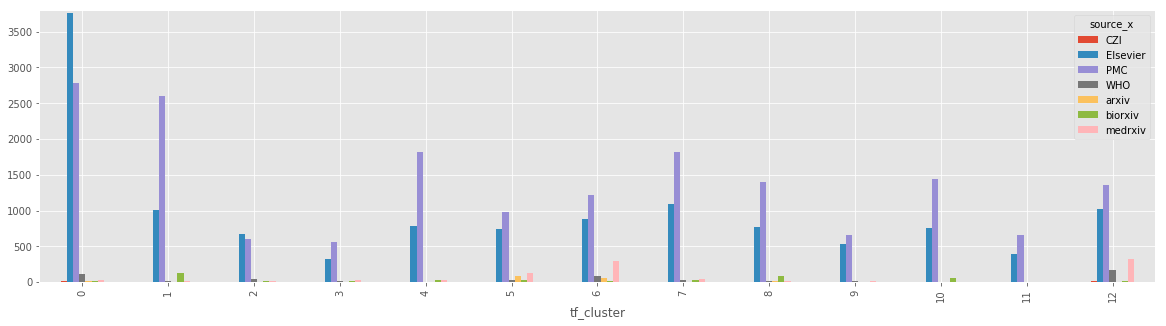

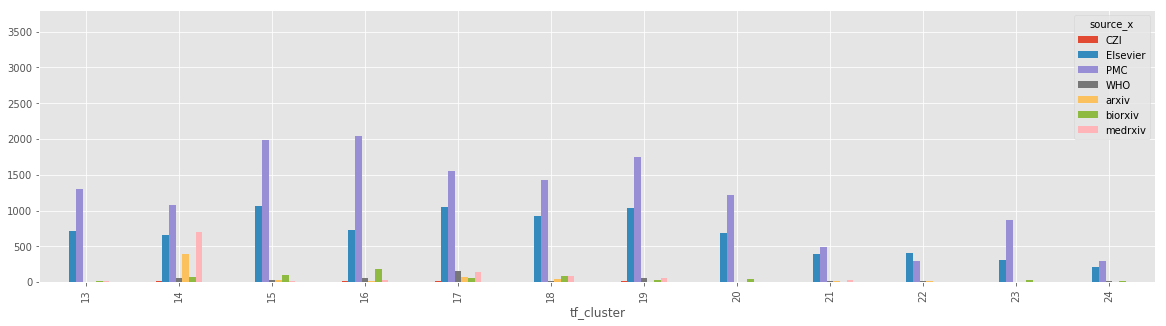

In [22]:
df_allen.query('tf_cluster < 13').groupby(['tf_cluster','source_x']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,3800))
df_allen.query('tf_cluster >= 13').groupby(['tf_cluster','source_x']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,3800))

#### Most common source (peer-reviewed / non-peer-reviewed)

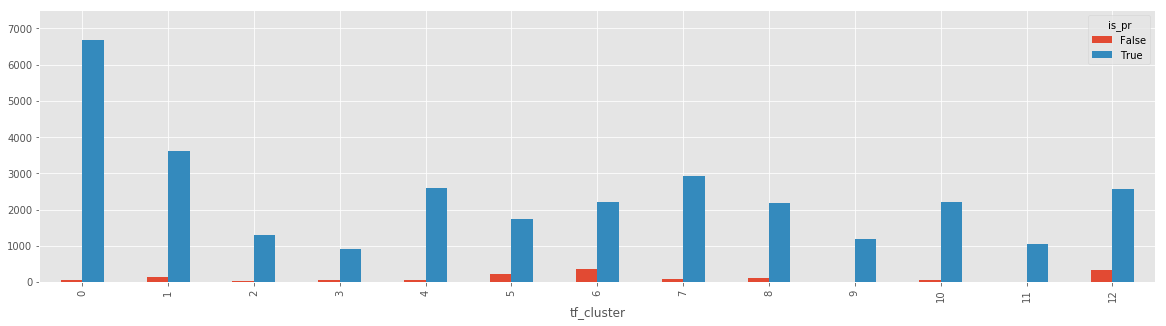

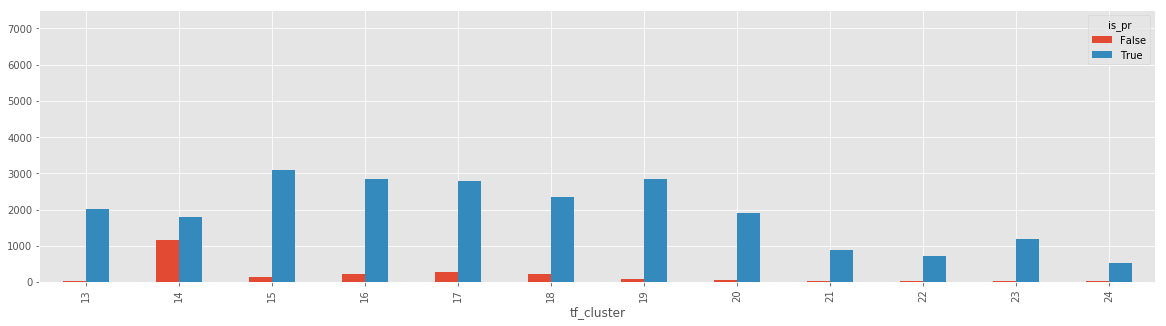

In [25]:
df_allen.query('tf_cluster < 13').groupby(['tf_cluster','is_pr']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,7500))
df_allen.query('tf_cluster >= 13').groupby(['tf_cluster','is_pr']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,7500))

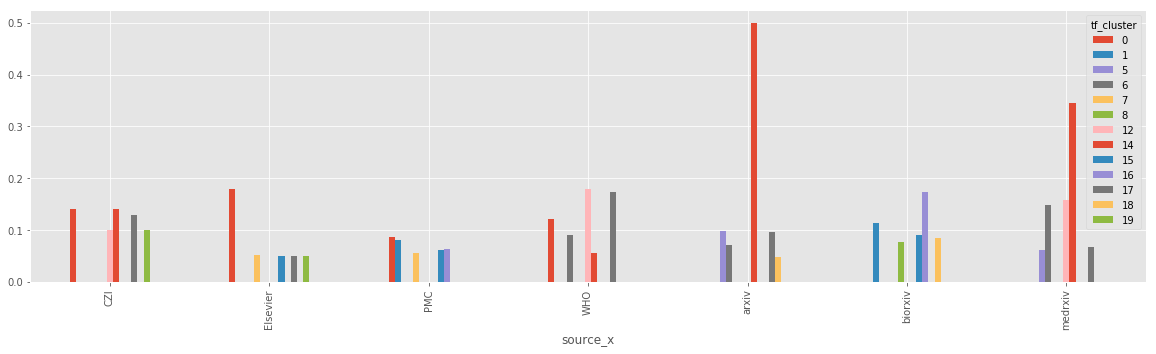

In [26]:
cl_p_source = df_allen.groupby(['source_x','tf_cluster'])['title'].count().unstack()
cl_p_source_rel = cl_p_source.div(cl_p_source.sum(axis=1), axis=0)
cl_p_source_rel.apply(lambda s: s.nlargest(5), axis=1).plot(kind='bar', figsize=(20,5))

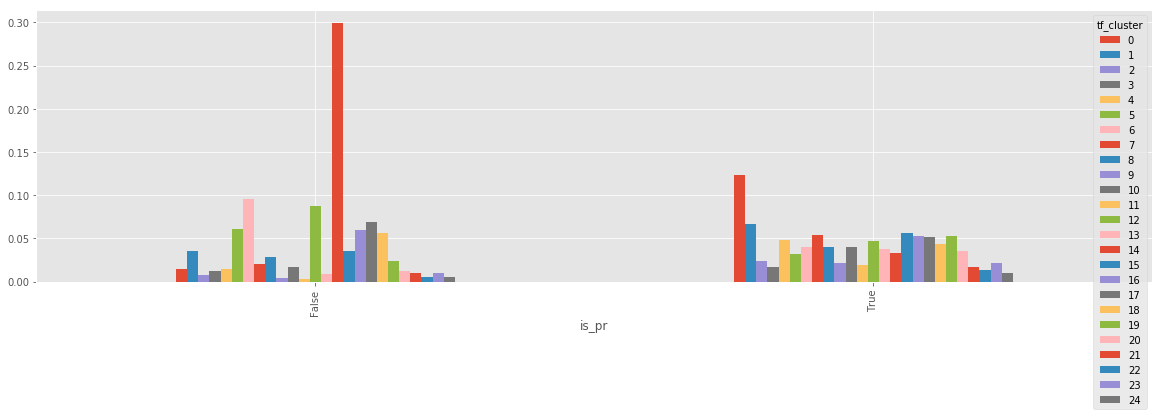

In [27]:
cl_p_source = df_allen.groupby(['is_pr','tf_cluster'])['title'].count().unstack()
cl_p_source_rel = cl_p_source.div(cl_p_source.sum(axis=1), axis=0)
cl_p_source_rel.plot(kind='bar', figsize=(20,5))

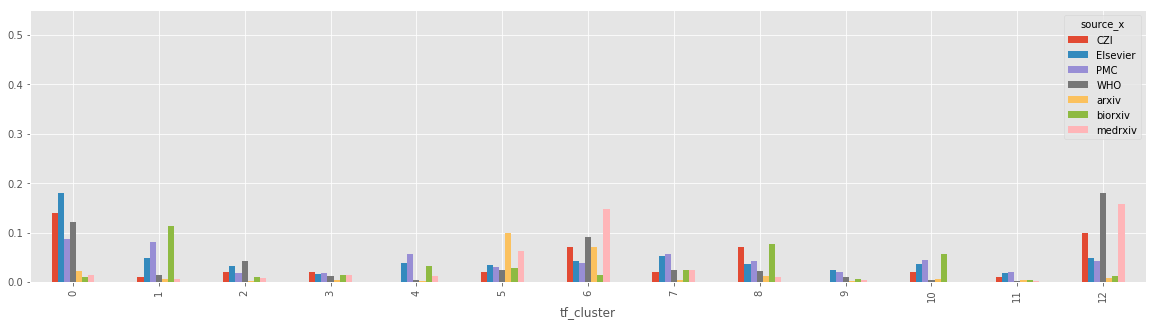

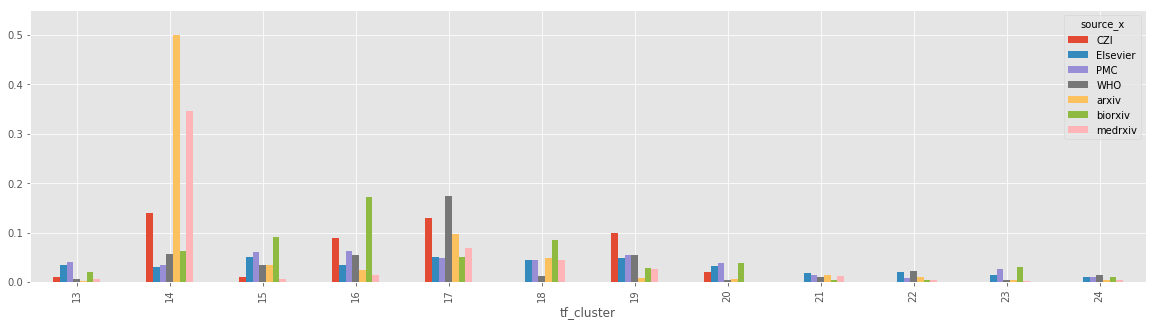

In [28]:
cl_p_source = df_allen.groupby(['source_x','tf_cluster'])['title'].count().unstack()
cl_p_source_rel = cl_p_source.div(cl_p_source.sum(axis=1), axis=0)
cl_p_source_rel.transpose().query('tf_cluster < 13').plot(kind='bar', figsize=(20,5), ylim=(0,0.55))
cl_p_source_rel.transpose().query('tf_cluster >= 13').plot(kind='bar', figsize=(20,5), ylim=(0,0.55))

In [29]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

E:\Python\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.149072  0.047481       1        1  7.259842
7      0.089540 -0.140924       2        1  6.618719
6      0.195859  0.075751       3        1  6.025416
4     -0.115684 -0.053805       4        1  5.930268
12     0.145000 -0.108042       5        1  5.831092
0      0.140683  0.080881       6        1  5.816830
1     -0.180482  0.049856       7        1  5.331933
11     0.064478  0.006850       8        1  5.171025
16    -0.015857  0.055139       9        1  5.167573
14    -0.093722  0.003150      10        1  4.359621
15    -0.097268  0.102192      11        1  4.328452
13    -0.145701 -0.074751      12        1  4.166342
2      0.002700 -0.205360      13        1  3.578055
19     0.013043 -0.147391      14        1  3.476527
5      0.168921  0.145073      15        1  3.461055
8      0.042631 -0.128593      16        1  2.759243
9      0.141192  0.060222      17        1  2.708938
22     0.042229  0.103492      18        1  2.561455
20    -0.076037 -0.031488      19        1  2.494953
18     0.064576 -0.026660      20        1  2.451419
3     -0.157759  0.051050      21        1  2.348660
21    -0.005589  0.060902      22        1  2.348521
23    -0.128491  0.069178      23        1  2.044437
17     0.015405  0.055874      24        1  1.948111
24     0.039406 -0.050077      25        1  1.811515, topic_info=     Category         Freq            Term        Total  loglift  logprob
3037  Default  2376.000000     respiratory  2376.000000  30.0000  30.0000
1753  Default  1495.000000      infectious  1495.000000  29.0000  29.0000
2576  Default   591.000000        pandemic   591.000000  28.0000  28.0000
1290  Default   365.000000          feline   365.000000  27.0000  27.0000
131   Default  1188.000000           acute  1188.000000  26.0000  26.0000
3178  Default  1136.000000          severe  1136.000000  25.0000  25.0000
1418  Default   717.000000          global   717.000000  24.0000  24.0000
2912  Default   845.000000          public   845.000000  23.0000  23.0000
1650  Default  1034.000000          immune  1034.000000  22.0000  22.0000
291   Default   865.000000       antiviral   865.000000  21.0000  21.0000
2914  Default   331.000000       pulmonary   331.000000  20.0000  20.0000
3804  Default  2488.000000           viral  2488.000000  19.0000  19.0000
578   Default   656.000000        cellular   656.000000  18.0000  18.0000
612   Default   315.000000         chinese   315.000000  17.0000  17.0000
3237  Default   399.000000          social   399.000000  16.0000  16.0000
3876  Default   323.000000        zoonotic   323.000000  15.0000  15.0000
2684  Default   301.000000    phylogenetic   301.000000  14.0000  14.0000
1760  Default   467.000000    inflammatory   467.000000  13.0000  13.0000
1783  Default   365.000000          innate   365.000000  12.0000  12.0000
1143  Default   242.000000         enteric   242.000000  11.0000  11.0000
3070  Default   153.000000       ribosomal   153.000000  10.0000  10.0000
647   Default  1404.000000        clinical  1404.000000   9.0000   9.0000
189   Default   155.000000        airborne   155.000000   8.0000   8.0000
2310  Default   194.000000         nervous   194.000000   7.0000   7.0000
1401  Default   343.000000         genomic   343.000000   6.0000   6.0000
1852  Default   246.000000      intestinal   246.000000   5.0000   5.0000
266   Default   629.000000            anti   629.000000   4.0000   4.0000
1286  Default   217.000000           fecal   217.000000   3.0000   3.0000
3795  Default   182.000000      veterinary   182.000000   2.0000   2.0000
3350  Default   147.000000      subgenomic   147.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
3449  Topic25    12.856438       tentative    15.555344   3.8204  -5.4898
1384  Topic25     9.199112         gaseous    11.082392   3.8248  -5.8245
1537  Topi

In [30]:
tfidf_cluster_assignment = lda_tfidf.transform(dtm_tfidf).argmax(axis=1)

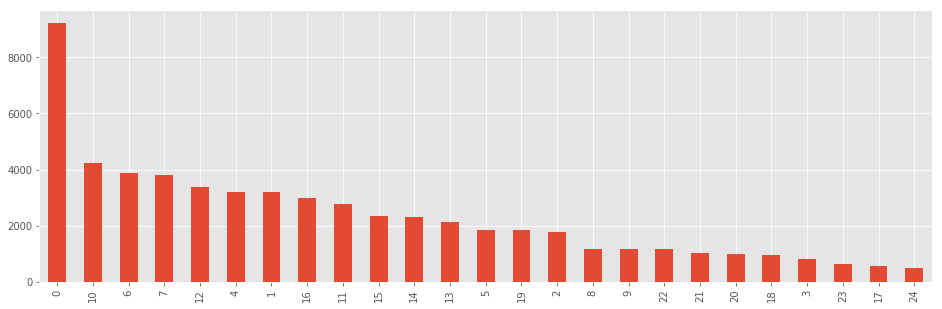

In [31]:
df_allen['tfidf_cluster'] = tfidf_cluster_assignment
df_allen.tfidf_cluster.value_counts().plot(kind='bar', figsize=(16,5))

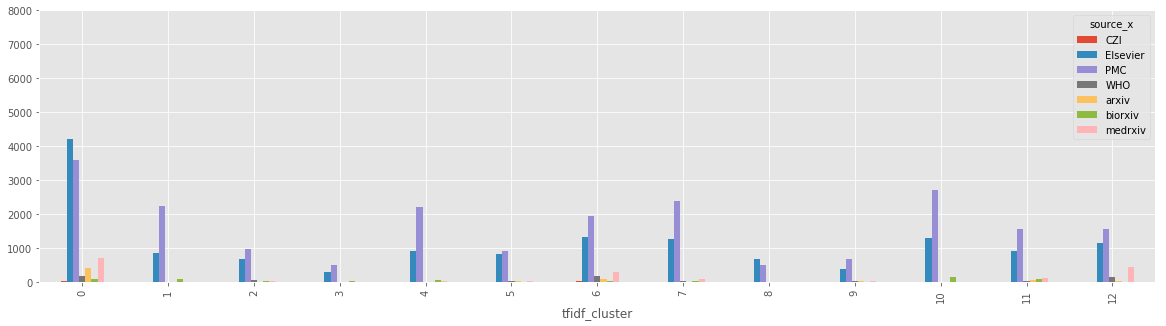

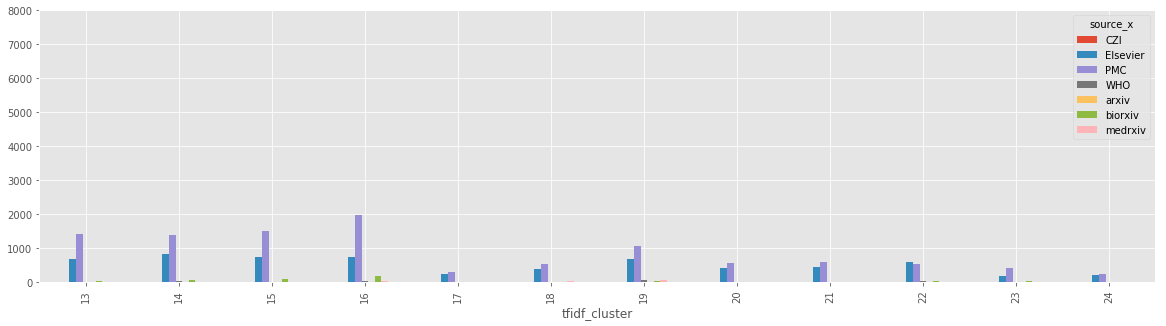

In [32]:
df_allen.query('tfidf_cluster < 13').groupby(['tfidf_cluster','source_x']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,8000))
df_allen.query('tfidf_cluster >= 13').groupby(['tfidf_cluster','source_x']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,8000))

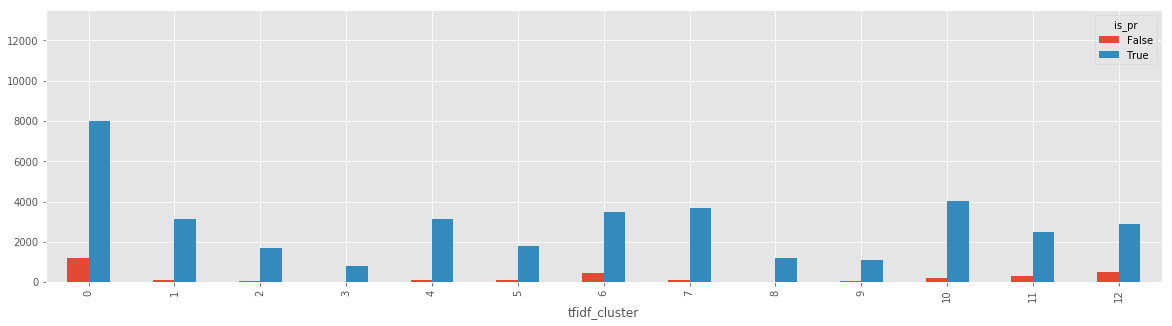

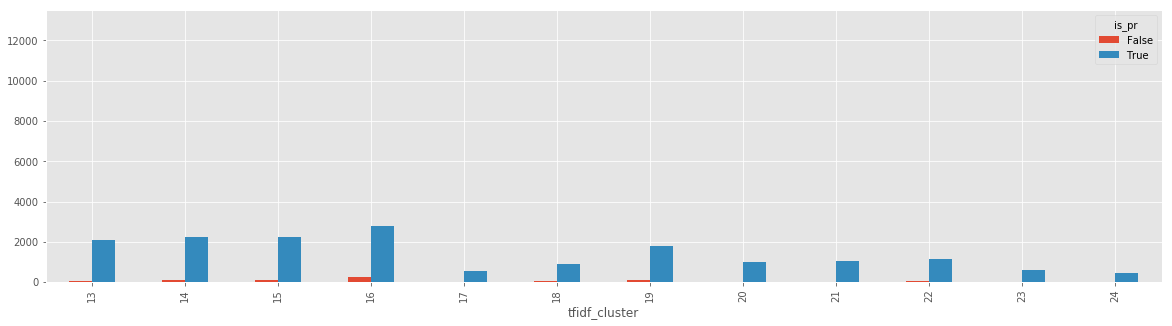

In [33]:
df_allen.query('tfidf_cluster < 13').groupby(['tfidf_cluster','is_pr']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,13500))
df_allen.query('tfidf_cluster >= 13').groupby(['tfidf_cluster','is_pr']).count().title.unstack().plot(kind='bar', figsize=(20,5), ylim=(0,13500))

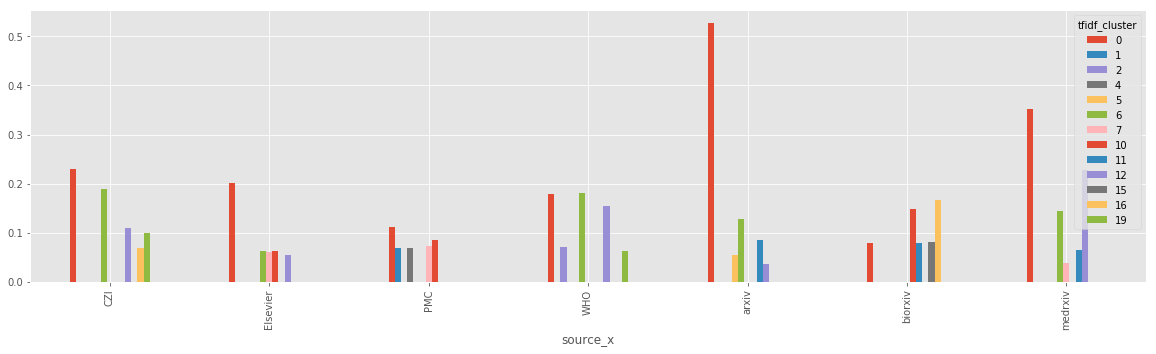

In [34]:
cl_p_source = df_allen.groupby(['source_x','tfidf_cluster'])['title'].count().unstack()
cl_p_source_rel = cl_p_source.div(cl_p_source.sum(axis=1), axis=0)
cl_p_source_rel.apply(lambda s: s.nlargest(5), axis=1).plot(kind='bar', figsize=(20,5))

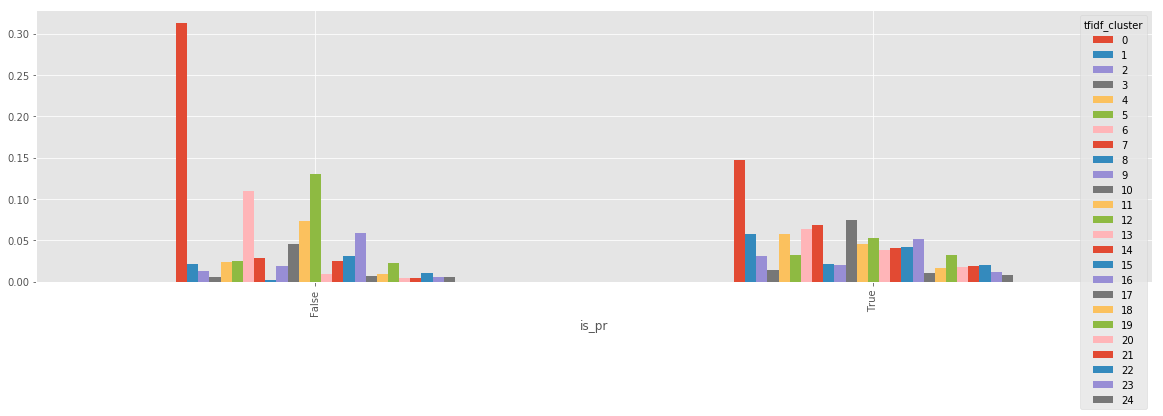

In [35]:
cl_p_source = df_allen.groupby(['is_pr','tfidf_cluster'])['title'].count().unstack()
cl_p_source_rel = cl_p_source.div(cl_p_source.sum(axis=1), axis=0)
cl_p_source_rel.plot(kind='bar', figsize=(20,5))

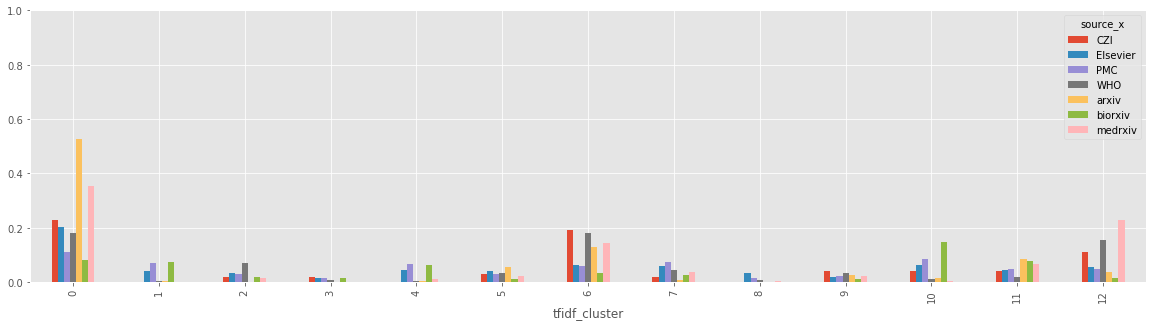

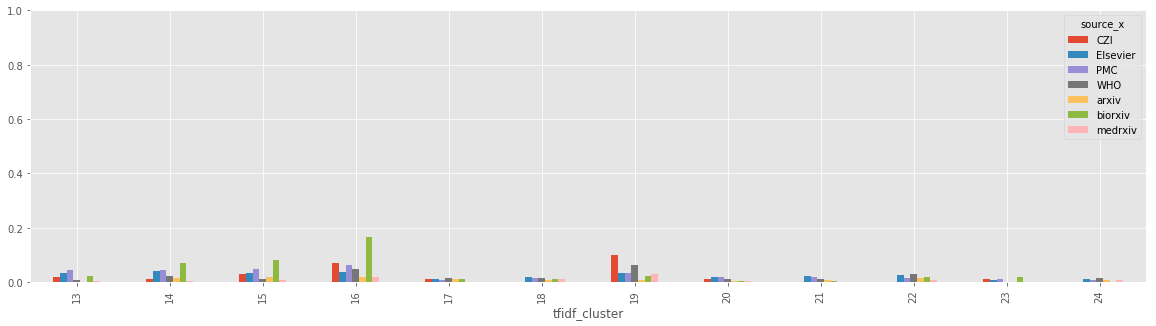

In [36]:
cl_p_source = df_allen.groupby(['source_x','tfidf_cluster'])['title'].count().unstack()
cl_p_source_rel = cl_p_source.div(cl_p_source.sum(axis=1), axis=0)
cl_p_source_rel.transpose().query('tfidf_cluster < 13').plot(kind='bar', figsize=(20,5), ylim=(0,1))
cl_p_source_rel.transpose().query('tfidf_cluster >= 13').plot(kind='bar', figsize=(20,5), ylim=(0,1))